# Latent Space Stability
This notebook explores the stability of the Latent Space in the HighDimSynthesizer.


---
### TL;DR
Using **beta=1.0 and 10,000 training steps** produces more stable latent space results compared to beta=2.0,3.0 and 20,000 training steps.
If we cycle the value of beta every 5000 training steps, the results are even more stable, though this is more complicated to do and the results are marginal.

---
Below we use the **synthesized.insight** module to work with a dataset's latent space. There are three utility functions used for fetching information about the latent space of a dataset. Each one listed below returns a more compact summary that the one above.
- `get_latent_space()`: returns the entire dataset encoded into the latent_space. 
    - The columns in the returned dataframe are l_0, ..., l_N-1, m_0, ..., m_N-1, s_0, ..., s_N-1. 
    - m_i is the encoded mean value for dimension i and each row, 
    - s_i is the encoded stddev for each dimension i and each row, 
    - and l_i is a sample from the encoded distribution in each dimension i and each row.
    - **returns a (num_rows, 3xnum_latent_dimensions) array as a DataFrame.**
- `latent_dimennsion_usage()`: returns the 'usage' of each dimension for the dataset (typically usage should be between 0 and 1). 
    - Note there are two ways to calculate this (see further down for details).
    - **returns a (num_latent_dimensions, 1) array as a DataFrame.**
- `total_latent_space_usage()`
    - **returns a scalar value reflecting the total latent space usage.**


In [1]:
import os
import warnings
from typing import List
import logging
import json

for module in ['numpy', 'pandas', 'seaborn', 'sklearn', 'tensorflow']:
    warnings.filterwarnings(action='ignore', module=module, append=True)

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(os.path.split(workbookDir)[0])[0])

pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Stability Experiments
---
We want to investigate the stability in the latent space for varying dataset sizes using some different model parameters that would likely affect latent space stability. We are interested in both the stability for the **same sample (experiment #1)** of a given size, and **different samples (experiment #2)** of a given size. 


- (x7) Variables:
    - (x1) dataset: 
        - **credit**
    - (x7) number of rows sampled from the dataset: 
        - **1000, 2000, 4000, 8000, 16000, 32000, 64000**

- (x6) Model Parameters:
    - (x2) number of training iterations: 
        - **10000, 20000**
    - (x3) beta:
        - **1.0, 2.0, 3.0**
 
- (x2) Measurement Parameters:
    - (x2) latent space usage type:
        - **"stddev"**: we can measure latent space usage in each dimension by considering the average 'stddev' for the dataset, $\sigma\text{-LSU}_n$.
        - **"mean"**: or we can measure the usage by considering the standard deviation of the 'mean' for the dataset, $\mu\text{-LSU}_n$.

- (x5) Experiment Parameters:
    - (x5) number of repeat trials (the dataset sample is the same in each repeat of exp-#1 and different in exp-#2).

The above gives a **total of 420 arms in each experiment**.



In [2]:
credit = pd.read_csv('data/templates/credit.csv')
exp_results = json.load(open('docs/latent_space/latent_stability_results.json', 'r'))

#### 1.1. Experiment 1: Effect of model parameters on LS stability of (identical) samples across different sample sizes.

In [3]:
df_exp1 = pd.DataFrame(exp_results['results'])
df_exp1 = df_exp1.rename(columns=lambda x: x[4:] if x[:4] == 'dim_' else x).melt(
    id_vars=['trial', 'num_rows', 'beta', 'num_iterations', 'random_seed', 'usage_type'],
    var_name='dimension', value_name='usage'
)
df_exp1

,trial,num_rows,beta,num_iterations,random_seed,usage_type,dimension,usage
0,3,1000,2.0,20000,161833,mean,0,1.014
1,3,1000,2.0,20000,161833,stddev,0,0.843
2,5,1000,1.0,20000,161833,mean,0,1.036
3,5,1000,1.0,20000,161833,stddev,0,0.827
4,2,64000,1.0,20000,161833,mean,0,0.989
...,...,...,...,...,...,...,...,...
13855,1,32000,3.0,10000,161833,stddev,total,4.374
13856,1,16000,3.0,20000,161833,mean,total,8.580
13857,1,16000,3.0,20000,161833,stddev,total,4.672
13858,1,4000,3.0,20000,161833,mean,total,8.866


##### 1.1.1. Total latent space usage stability - Effect of Beta

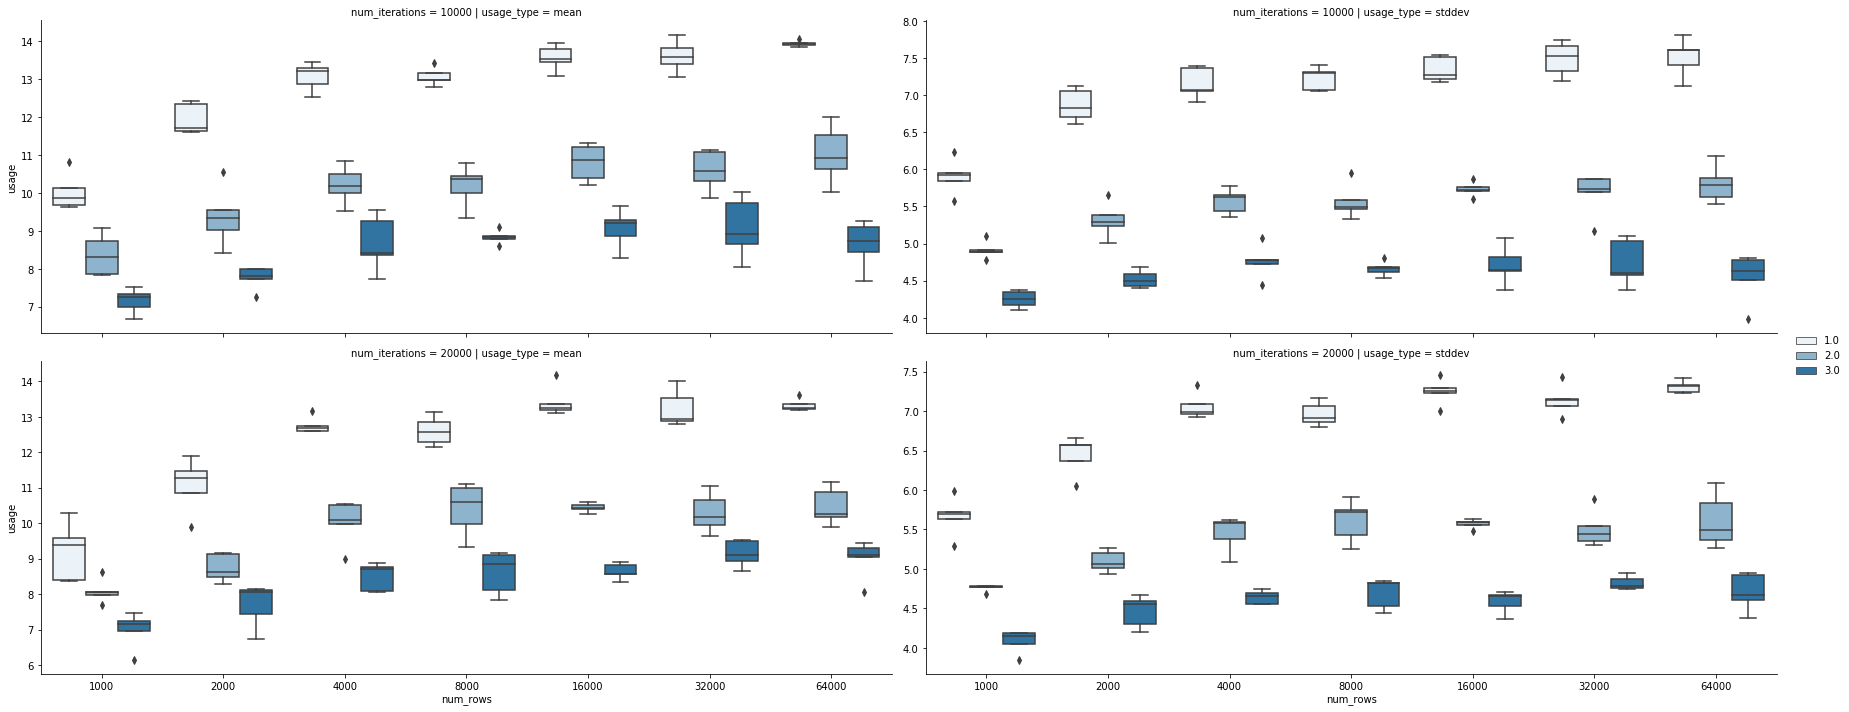

In [4]:
df_exp1_tot = df_exp1[df_exp1['dimension']=='total']

g = sns.FacetGrid(df_exp1_tot, row='num_iterations', col='usage_type', aspect=2.5, height=5, sharey=False)
g.map(sns.boxplot, 'num_rows', 'usage', 'beta').add_legend()

##### 1.1.2. Total latent space usage stability - Effect of num_iterations

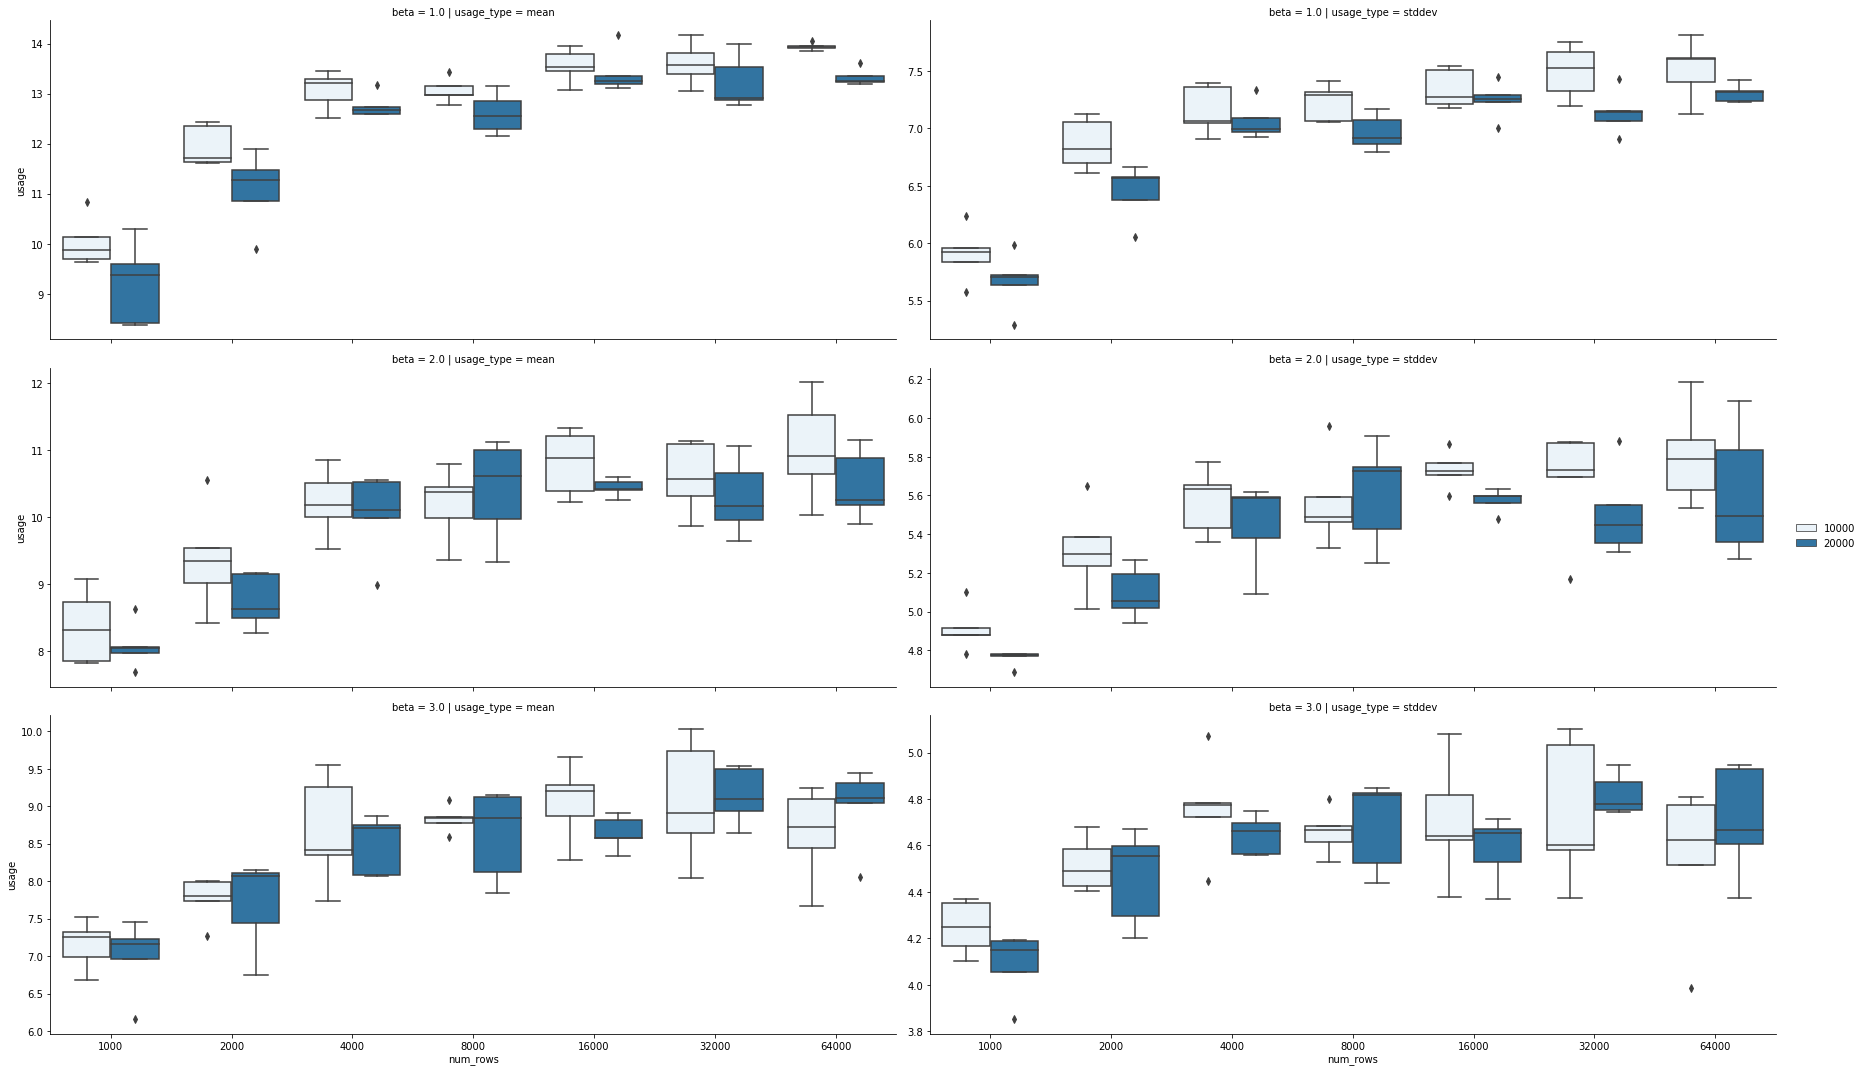

In [5]:
g = sns.FacetGrid(df_exp1_tot, row='beta', col='usage_type', aspect=2.5, height=5, sharey=False)
g.map(sns.boxplot, 'num_rows', 'usage', 'num_iterations').add_legend()

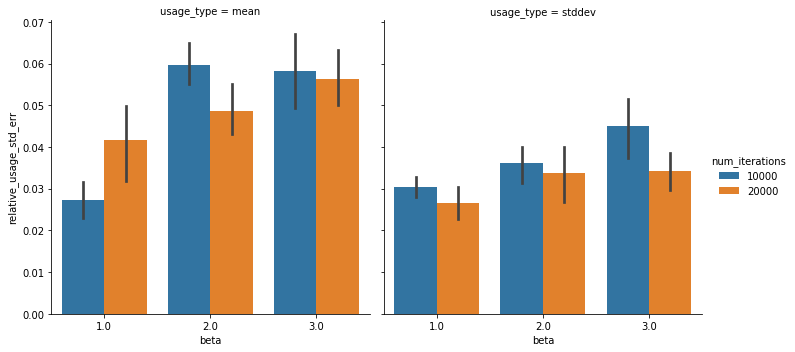

In [6]:
df = df_exp1_tot.loc[:,['beta','usage_type', 'num_iterations', 'num_rows', 'usage']].groupby(['beta', 'usage_type', 'num_iterations', 'num_rows']).var()
df2 = df_exp1_tot.loc[:,['beta','usage_type', 'num_iterations', 'num_rows', 'usage']].groupby(['beta', 'usage_type', 'num_iterations', 'num_rows']).mean()
df = df**0.5/df2
df = df.reset_index().rename(columns=lambda x: 'relative_usage_std_err' if x =='usage' else x)
sns.catplot(kind='bar', data=df, 
            y='relative_usage_std_err', col='usage_type', x='beta', hue='num_iterations',
            ci=67, estimator=np.mean
           )

#### 1.2. Experiment 2: Effect of model parameters on LS stability of (non-identical) samples across different sample sizes.

In [7]:
df_exp2 = pd.DataFrame(exp_results['results_2'])
df_exp2 = df_exp2.rename(columns=lambda x: x[4:] if x[:4] == 'dim_' else x).melt(
    id_vars=['trial', 'num_rows', 'beta', 'num_iterations', 'random_seed', 'usage_type'],
    var_name='dimension', value_name='usage'
)
df_exp2

,trial,num_rows,beta,num_iterations,random_seed,usage_type,dimension,usage
0,1,16000,1.0,10000,461833,mean,0,1.026
1,1,16000,1.0,10000,461833,stddev,0,0.819
2,1,16000,2.0,10000,161833,mean,0,1.003
3,1,16000,2.0,10000,161833,stddev,0,0.846
4,1,1000,1.0,10000,261833,mean,0,1.020
...,...,...,...,...,...,...,...,...
9235,1,64000,2.0,10000,261833,stddev,total,5.819
9236,1,2000,2.0,10000,161833,mean,total,9.223
9237,1,2000,2.0,10000,161833,stddev,total,5.054
9238,1,8000,2.0,10000,161833,mean,total,11.388


##### 1.2.1. Total latent space usage stability - Effect of Beta

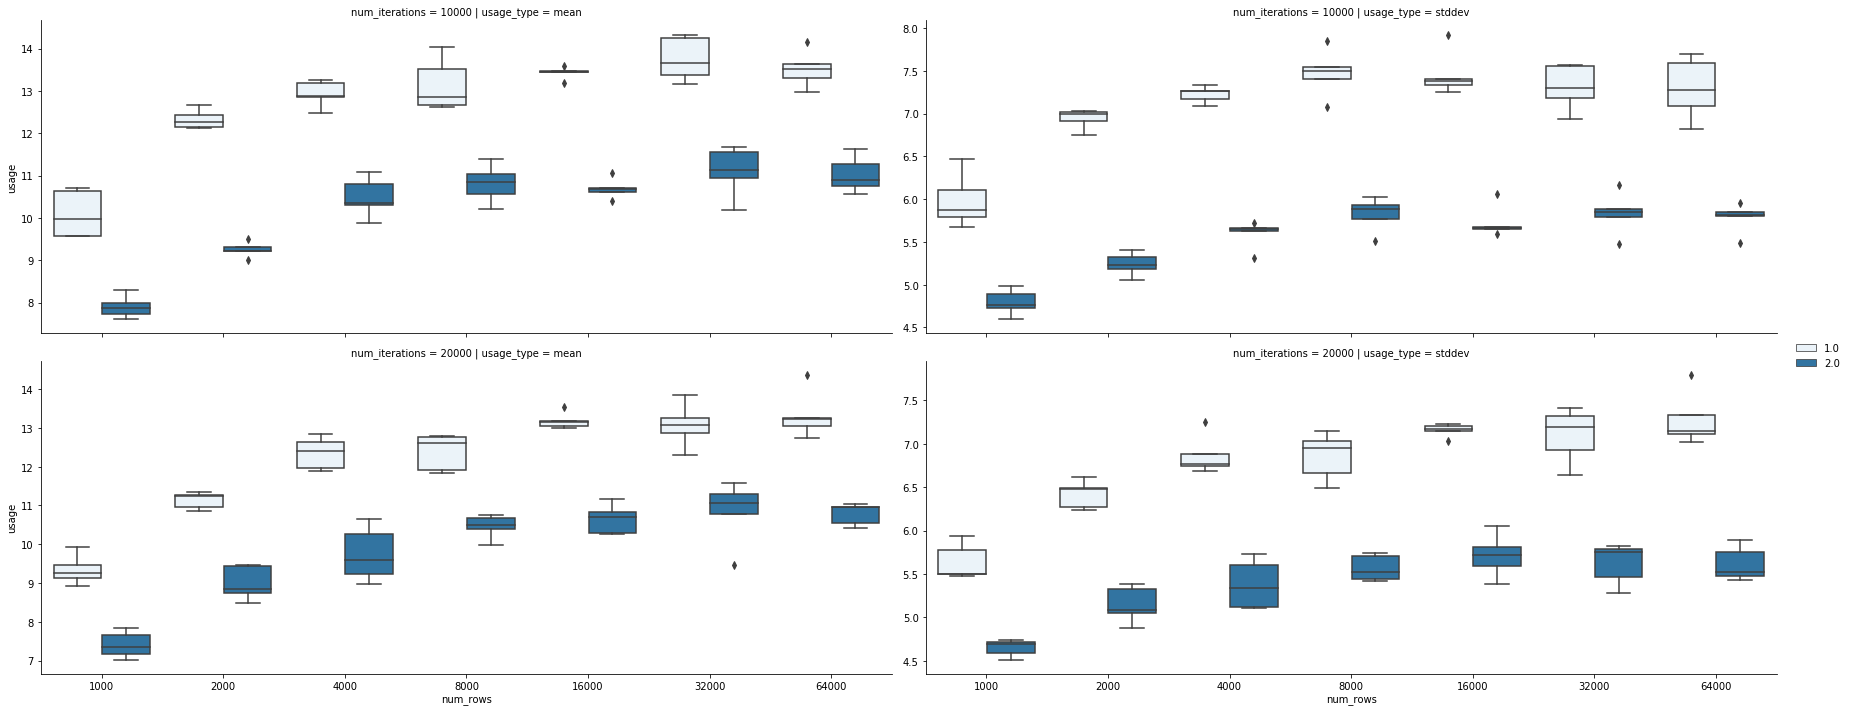

In [8]:
df_exp2_tot = df_exp2[df_exp2['dimension']=='total']

g = sns.FacetGrid(df_exp2_tot, row='num_iterations', col='usage_type', aspect=2.5, height=5, sharey=False)
g.map(sns.boxplot, 'num_rows', 'usage', 'beta').add_legend()

##### 1.2.2. Total latent space usage stability - Effect of num_iterations

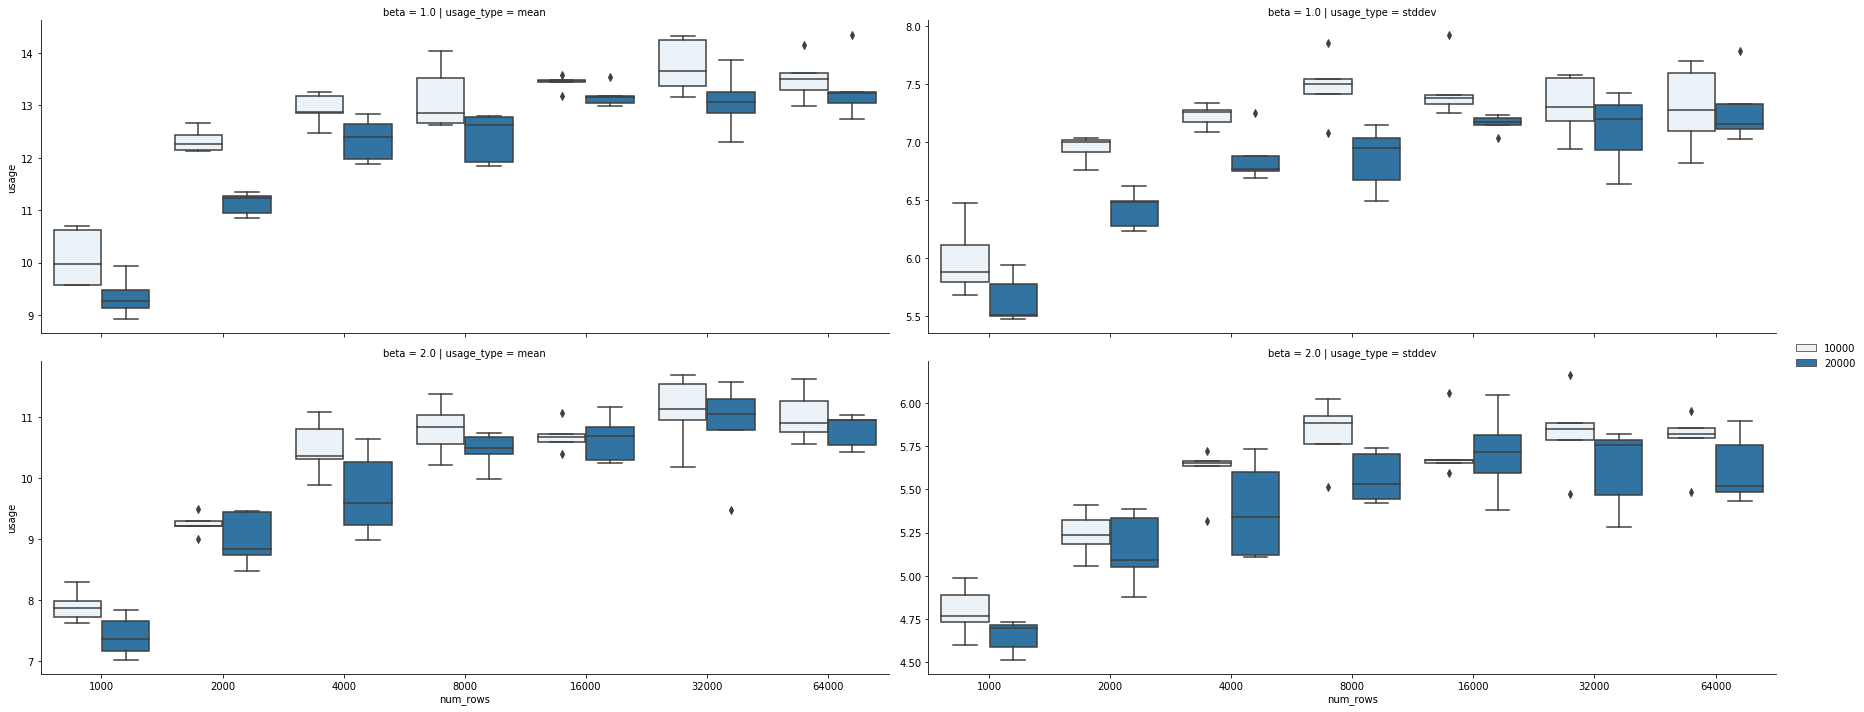

In [9]:
g = sns.FacetGrid(df_exp2_tot, row='beta', col='usage_type', aspect=2.5, height=5, sharey=False)
g.map(sns.boxplot, 'num_rows', 'usage', 'num_iterations').add_legend()

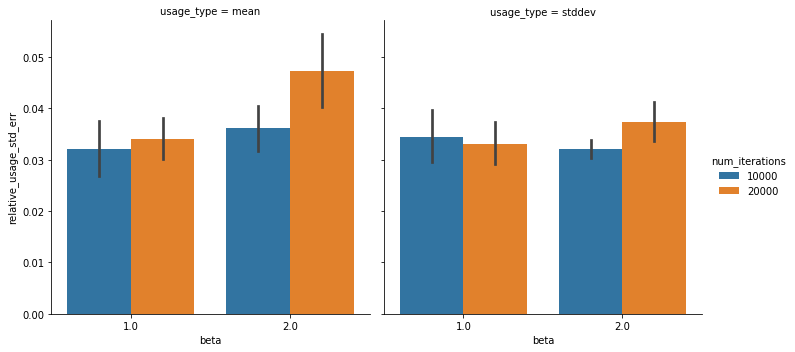

In [10]:
df = df_exp2_tot.loc[:,['beta','usage_type', 'num_iterations', 'num_rows', 'usage']].groupby(['beta', 'usage_type', 'num_iterations', 'num_rows']).var()
df2 = df_exp2_tot.loc[:,['beta','usage_type', 'num_iterations', 'num_rows', 'usage']].groupby(['beta', 'usage_type', 'num_iterations', 'num_rows']).mean()
df = df**0.5/df2
df = df.reset_index().rename(columns=lambda x: 'relative_usage_std_err' if x =='usage' else x)
sns.catplot(kind='bar', data=df, 
            y='relative_usage_std_err', col='usage_type', x='beta', hue='num_iterations',
            ci=67, estimator=np.mean
           )

#### 1.3. Experiment 3:  Effect of Beta Cycling on Latent Space Stability

In [11]:
df_exp3 = pd.DataFrame(exp_results['results_5k_cycle'])
df_exp3 = df_exp3.rename(columns=lambda x: x[4:] if x[:4] == 'dim_' else x).melt(
    id_vars=['trial', 'num_rows', 'beta', 'num_iterations', 'random_seed', 'usage_type'],
    var_name='dimension', value_name='usage'
)

df_orig = df_exp1[df_exp1['beta']==1.0].copy()
df_exp3['option'] = '5k_beta_cycle'
df_orig['option'] = 'original'

df_exp3 = pd.concat((df_exp3, df_orig), axis=0, sort=False)
df_exp3

,trial,num_rows,beta,num_iterations,random_seed,usage_type,dimension,usage,option
0,2,16000,1.0,20000,161833,mean,0,0.987,5k_beta_cycle
1,2,16000,1.0,20000,161833,stddev,0,0.762,5k_beta_cycle
2,4,64000,1.0,20000,161833,mean,0,1.002,5k_beta_cycle
3,4,64000,1.0,20000,161833,stddev,0,0.818,5k_beta_cycle
4,4,32000,1.0,10000,161833,mean,0,0.993,5k_beta_cycle
...,...,...,...,...,...,...,...,...,...
13703,5,8000,1.0,20000,161833,stddev,total,7.070,original
13704,1,16000,1.0,10000,161833,mean,total,13.535,original
13705,1,16000,1.0,10000,161833,stddev,total,7.216,original
13710,5,32000,1.0,10000,161833,mean,total,13.387,original


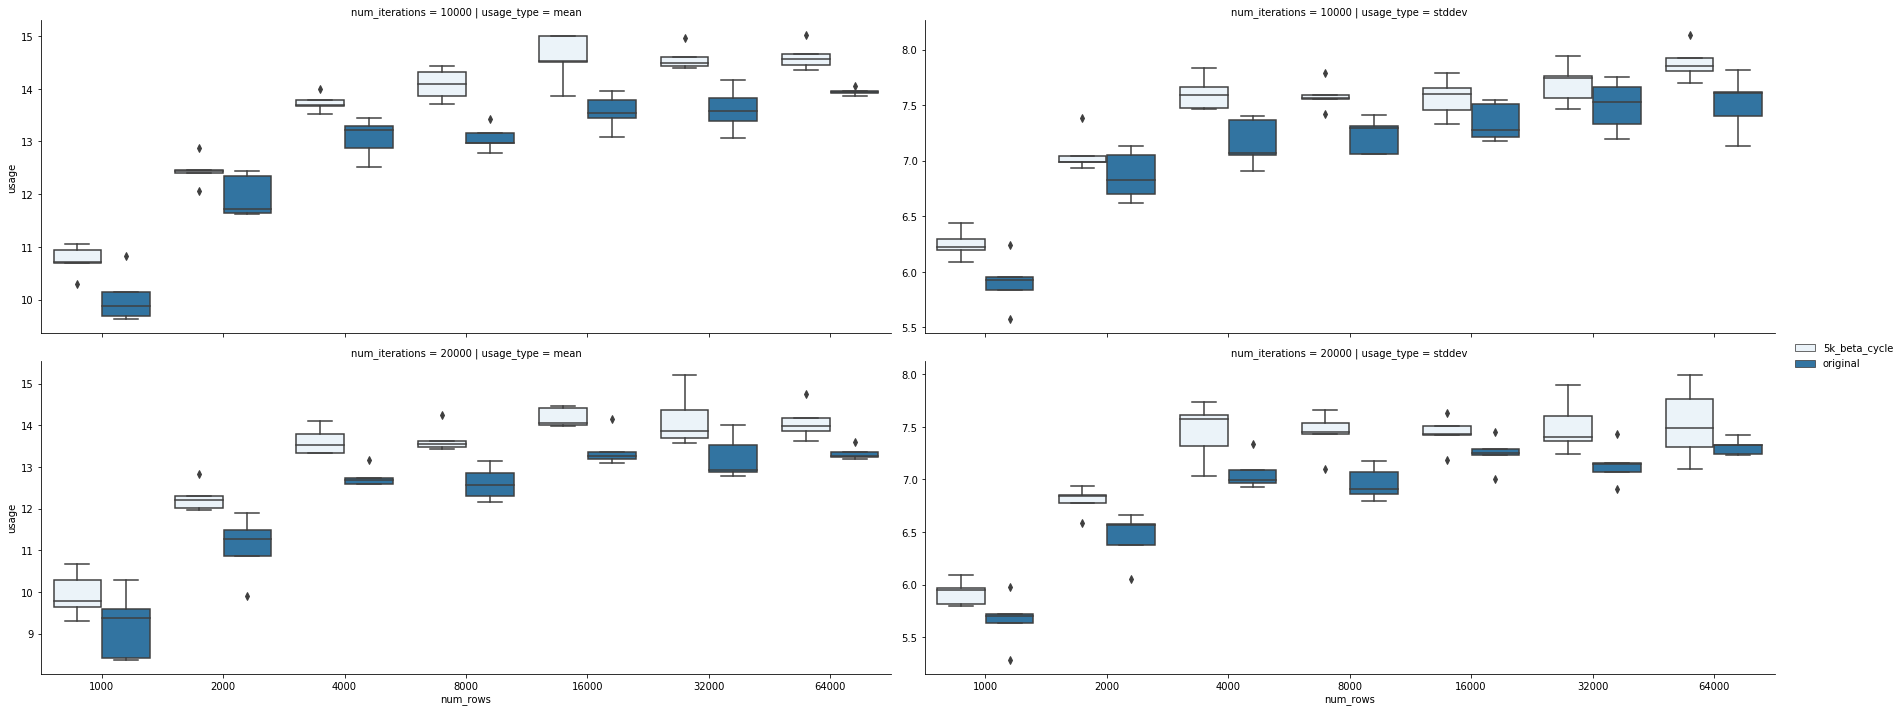

In [12]:
df_exp3_tot = df_exp3[df_exp3['dimension']=='total']

g = sns.FacetGrid(df_exp3_tot, row='num_iterations', col='usage_type', aspect=2.5, height=5, sharey=False)
g.map(sns.boxplot, 'num_rows', 'usage', 'option').add_legend()

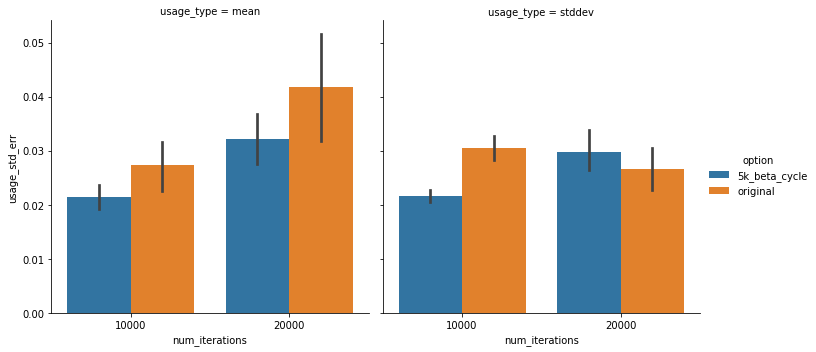

In [13]:
df = df_exp3_tot.loc[:,['beta','usage_type', 'num_iterations', 'num_rows', 'usage', 'option']].groupby(['beta', 'usage_type', 'num_iterations', 'num_rows', 'option']).var()
df2 = df_exp3_tot.loc[:,['beta','usage_type', 'num_iterations', 'num_rows', 'usage', 'option']].groupby(['beta', 'usage_type', 'num_iterations', 'num_rows', 'option']).mean()
df = df**0.5/df2
df = df.reset_index().rename(columns=lambda x: 'usage_std_err' if x =='usage' else x)
sns.catplot(
    kind='bar', data=df, 
    y='usage_std_err', col='usage_type', x='num_iterations', hue='option',
    ci=67, estimator=np.mean
)

#### 1.4. Experiment 4:  Effect of Slow KL expansion on Latent Space Stability

In [16]:
df_exp4 = pd.DataFrame(exp_results['results_slow_kl_expansion'])
df_exp4 = df_exp4.rename(columns=lambda x: x[4:] if x[:4] == 'dim_' else x).melt(
    id_vars=['trial', 'num_rows', 'beta', 'num_iterations', 'random_seed', 'usage_type'],
    var_name='dimension', value_name='usage'
)

df_orig = df_exp1[df_exp1['beta']==1.0][df_exp1['num_iterations']==20000].copy()
df_exp4['option'] = 'slow_kl_expansion'
df_orig['option'] = 'original'

df_exp4 = pd.concat((df_exp4, df_orig), axis=0, sort=False)
df_exp4

/Users/simonhkswan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,trial,num_rows,beta,num_iterations,random_seed,usage_type,dimension,usage,option
0,2,16000,5.0,20000,161833,mean,0,0.710,slow_kl_expansion
1,2,16000,5.0,20000,161833,stddev,0,0.950,slow_kl_expansion
2,4,4000,5.0,20000,161833,mean,0,0.714,slow_kl_expansion
3,4,4000,5.0,20000,161833,stddev,0,0.950,slow_kl_expansion
4,2,4000,5.0,20000,161833,mean,0,0.681,slow_kl_expansion
...,...,...,...,...,...,...,...,...,...
13697,5,32000,1.0,20000,161833,stddev,total,7.435,original
13700,1,2000,1.0,20000,161833,mean,total,11.898,original
13701,1,2000,1.0,20000,161833,stddev,total,6.660,original
13702,5,8000,1.0,20000,161833,mean,total,13.147,original


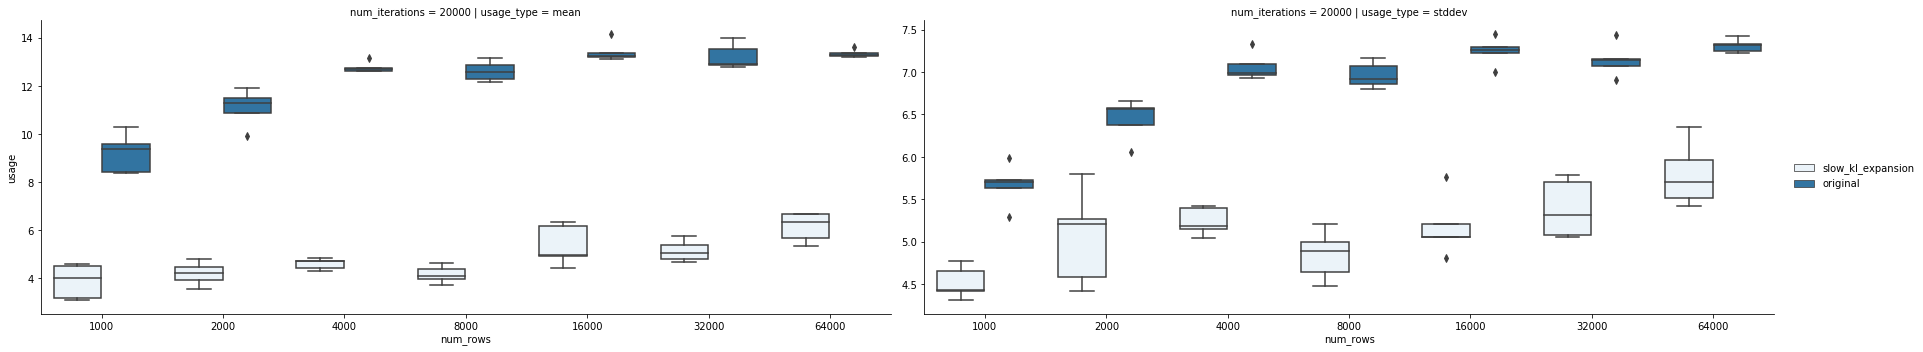

In [17]:
df_exp4_tot = df_exp4[df_exp4['dimension']=='total']

g = sns.FacetGrid(df_exp4_tot, row='num_iterations', col='usage_type', aspect=2.5, height=5, sharey=False)
g.map(sns.boxplot, 'num_rows', 'usage', 'option').add_legend()

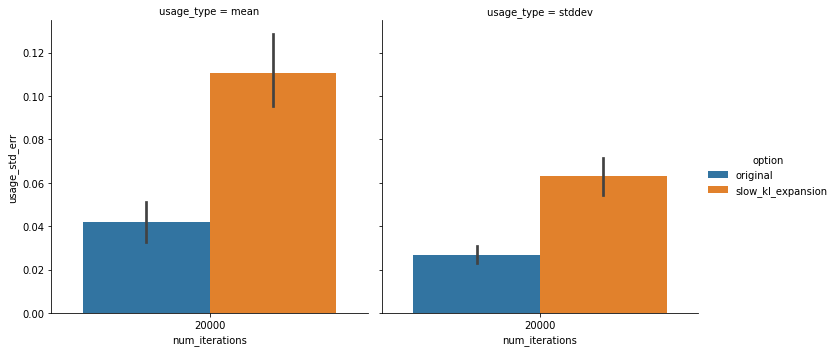

In [18]:
df = df_exp4_tot.loc[:,['beta','usage_type', 'num_iterations', 'num_rows', 'usage', 'option']].groupby(['beta', 'usage_type', 'num_iterations', 'num_rows', 'option']).var()
df2 = df_exp4_tot.loc[:,['beta','usage_type', 'num_iterations', 'num_rows', 'usage', 'option']].groupby(['beta', 'usage_type', 'num_iterations', 'num_rows', 'option']).mean()
df = df**0.5/df2
df = df.reset_index().rename(columns=lambda x: 'usage_std_err' if x =='usage' else x)
sns.catplot(
    kind='bar', data=df, 
    y='usage_std_err', col='usage_type', x='num_iterations', hue='option',
    ci=67, estimator=np.mean
)